# Preliminary code usage

Highly suggest to use a venv to code this project

To create your venv, install venv if necessary:

```bash
mkdir .venv 
python3 -m venv .venv
source .venv/bin/activate
```

To install the requirements:

```bash
pip install -r requirements.txt
```


Make sure to use .venv python as kernel in jupyter notebook

```bash

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
#import pyActigraphy


### Magnitude

In [27]:
data_folder = '../raw_data/'

df = pd.read_csv(data_folder + '1_AHA_RAW.csv')

len(df) / 80 
1200/60


20.0

In [3]:
magnitude_D = np.sqrt(np.square(df['x_D']) + np.square(df['y_D']) + np.square(df['z_D'])) #mano dominante
magnitude_ND = np.sqrt(np.square(df['x_ND']) + np.square(df['y_ND']) + np.square(df['z_ND'])) #mano non dominante

### Operations with time-series' magnitude
- concatenation
- difference (btw domaninat and non dominant)
- asymmetrix index (ai)

In [4]:
#compute asimmetry index and difference given magnitude 
def elaborate_magnitude(operation_type, magnitude_D, magnitude_ND):

    elaborated_magnitude = []
    
    '''
    penso sia inutile usare la concatenazione come indice 

    if operation_type == 'concat':
        elaborated_magnitude = pd.concat([magnitude_D, magnitude_ND], ignore_index=True)
    '''

    if operation_type == 'difference':
        elaborated_magnitude = magnitude_D - magnitude_ND
    elif operation_type == 'ai':
        elaborated_magnitude = (((magnitude_D - magnitude_ND) / (magnitude_D + magnitude_ND)) * 100).fillna(0)
    else: 
        print('operation type non supportata.')
        exit(1)

    return elaborated_magnitude

In [5]:
#create window_size
def create_windows(folder, operation_type, WINDOW_SIZE):
    series = []
    y_AHA = []
    y_MACS =[]
    y = []
    metadata = pd.read_excel(folder + 'metadata2022_04.xlsx')

    for j in range (1, metadata.shape[0]+1):
        df = pd.read_csv(folder + 'data/' + str(j) + '_AHA_1sec.csv')

        #print('Paziente ' + str(j) + ' -> df.shape[0] = ' + str(df.shape[0]))

        # Nel caso in cui non bastasse una duplicazione dell'intera time series questa verrà scartata
        if df.shape[0]<WINDOW_SIZE:
            df_concat = pd.concat([df, df.iloc[:WINDOW_SIZE-df.shape[0]]], ignore_index = True, axis = 0)
            df = df_concat
            #print('MODIFICATO Paziente ' + str(j) + ' -> df.shape[0] = ' + str(df.shape[0]))

        scart = (df.shape[0] % WINDOW_SIZE)/2
        
        df_cut = df.iloc[math.ceil(scart):df.shape[0]-math.floor(scart)]


        # Calculating magnitude
        magnitude_D = np.sqrt(np.square(df_cut['x_D']) + np.square(df_cut['y_D']) + np.square(df_cut['z_D']))
        magnitude_ND = np.sqrt(np.square(df_cut['x_ND']) + np.square(df_cut['y_ND']) + np.square(df_cut['z_ND']))
        for i in range (0, len(magnitude_D), WINDOW_SIZE):
            chunk_D = magnitude_D.iloc[i:i + WINDOW_SIZE]
            chunk_ND = magnitude_ND.iloc[i:i + WINDOW_SIZE]
            series.append(elaborate_magnitude(operation_type, chunk_D, chunk_ND))
            y_AHA.append(metadata['AHA'].iloc[j-1])
            y_MACS.append(metadata['MACS'].iloc[j-1])
            y.append(metadata['hemi'].iloc[j-1]-1)
    
    return np.array(series), y_AHA, y_MACS, np.array(y)

In [6]:
# Fase di chunking (OPTIONAL)
#Need to select a window size

    for j in range (0, len(magnitude_D), window_size):

        chunk_D = magnitude_D.iloc[j:j + window_size]
        chunk_ND = magnitude_ND.iloc[j:j + window_size]

        if chunk_D.size == window_size and chunk_ND.size == window_size:
            
            for es in estimators:
                es['series'].append(elaborate_magnitude(es['method'], chunk_D, chunk_ND))

            if chunk_D.agg('sum') == 0 and chunk_ND.agg('sum') == 0:
                to_discard.append(int(j/window_size))

IndentationError: unexpected indent (4202332419.py, line 4)

### Preprocessing starting from raw data

In [ ]:
# Nella tesi di triennale non fanno un cazzo di pre-processing, prendono direttamente x, y, z dalle time-series



### Correlation analysis

- correlation btw WEEK sessions and Clinical sessions (1h) --> sliding
- Define what is the kernel, clinical or week? Id say the clical (20 min) over week, taking one day of the week maybe or iterate over more days

                          datetime    x_D    y_D    z_D   x_ND   y_ND   z_ND
0       2017-05-04 00:00:00.000000 -0.949  0.035  0.273 -0.957  0.008  0.277
1       2017-05-04 00:00:00.012500 -0.953  0.027  0.273 -0.957  0.000  0.277
2       2017-05-04 00:00:00.025000 -0.953  0.027  0.266 -0.961  0.000  0.270
3       2017-05-04 00:00:00.037500 -0.949  0.023  0.266 -0.957  0.000  0.273
4       2017-05-04 00:00:00.050000 -0.949  0.023  0.270 -0.957 -0.004  0.273
...                            ...    ...    ...    ...    ...    ...    ...
999995  2017-05-04 03:28:19.937500 -0.949  0.023  0.273 -0.957 -0.004  0.281
999996  2017-05-04 03:28:19.950000 -0.949  0.023  0.270 -0.957  0.000  0.277
999997  2017-05-04 03:28:19.962500 -0.949  0.020  0.273 -0.957 -0.004  0.270
999998  2017-05-04 03:28:19.975000 -0.949  0.023  0.277 -0.961 -0.004  0.273
999999  2017-05-04 03:28:19.987500 -0.949  0.016  0.273 -0.965  0.000  0.270

[1000000 rows x 7 columns]


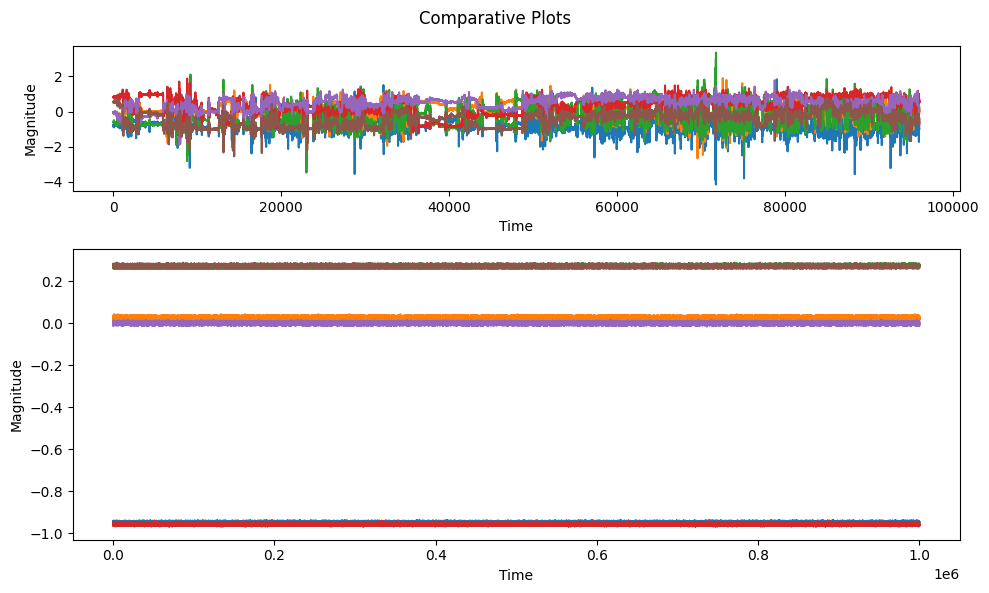

In [37]:
#Nella tesi di triennale usano semplicemente corrcoef ma così non fai sliding

# take n hours of data from the patient
df_h = df
SAMPLING_RATE = 80


# Take only a part of data
# csv is big taking it in chunks
chunksize = 10 ** 6

for chunk in pd.read_csv(data_folder + '1_week_RAW.csv', chunksize=chunksize):
    df_week_chunk = chunk
    break

print(df_week_chunk)

# So our kernel is 1 hour long and we slide it over the rest of the week (using chunk or not if you can make it work)

# Sliding cross correlating
# take only x_D, y_D, z_D, x_ND, y_ND, z_ND and compute correlation between df_1h and df_week_chunk

import scipy.stats as stats
from scipy import signal

#Discard date from dfs
df_h = df_h.drop(['datetime'], axis=1)
df_week_chunk = df_week_chunk.drop(['datetime'], axis=1)
 
fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [1, 2]}, figsize=(10, 6))
fig.suptitle('Comparative Plots')

# plot for 2 hour taken
axs[0].plot(df_h)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Magnitude')

# plot for week
axs[1].plot(df_week_chunk)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

# Correlation with the kernel

c:\Users\lucam\anaconda3\envs\python3115\Lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\lucam\anaconda3\envs\python3115\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


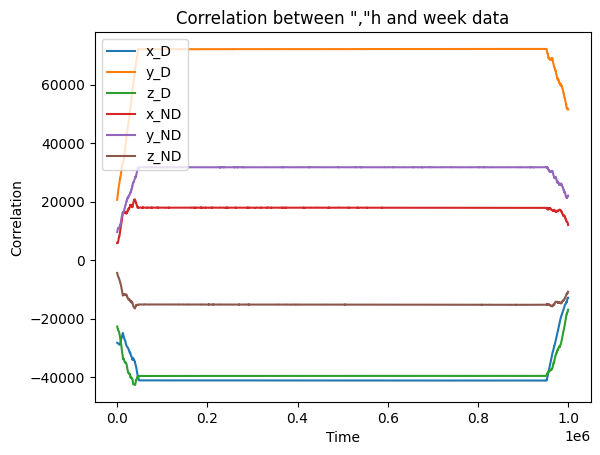

In [38]:

kernel_to_slide = df_h

correlation = signal.correlate(df_week_chunk, kernel_to_slide, mode='same')

plt.plot(correlation)


#naming on different axis
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('Correlation between ","h and week data')

# legenda for the x_D, y_D, z_D, x_ND, y_ND, z_ND
plt.legend(['x_D', 'y_D', 'z_D', 'x_ND', 'y_ND', 'z_ND'])



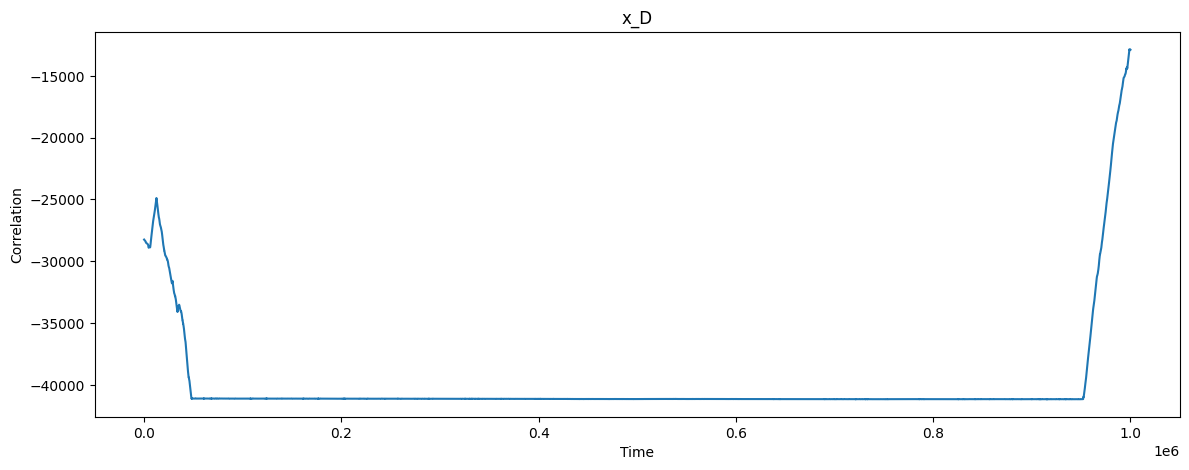

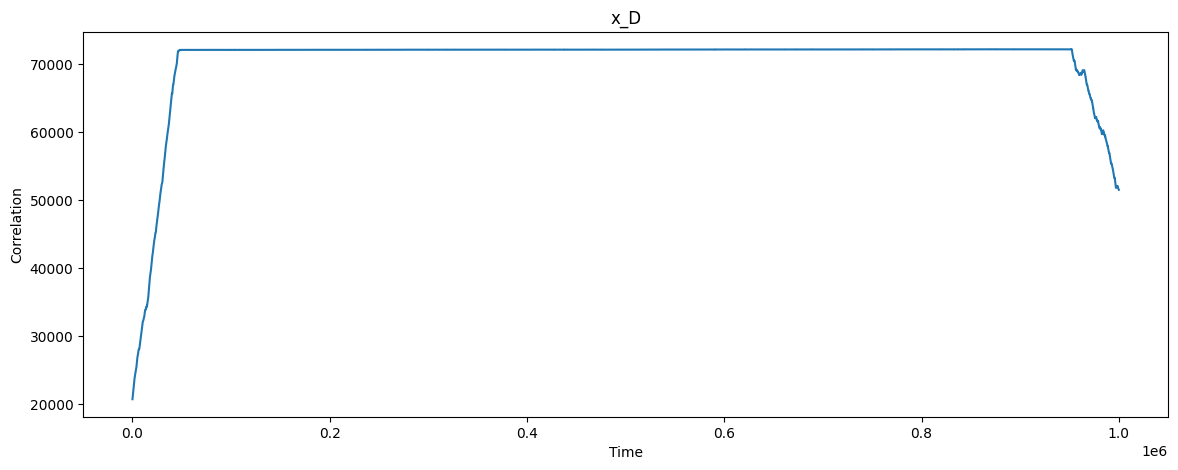

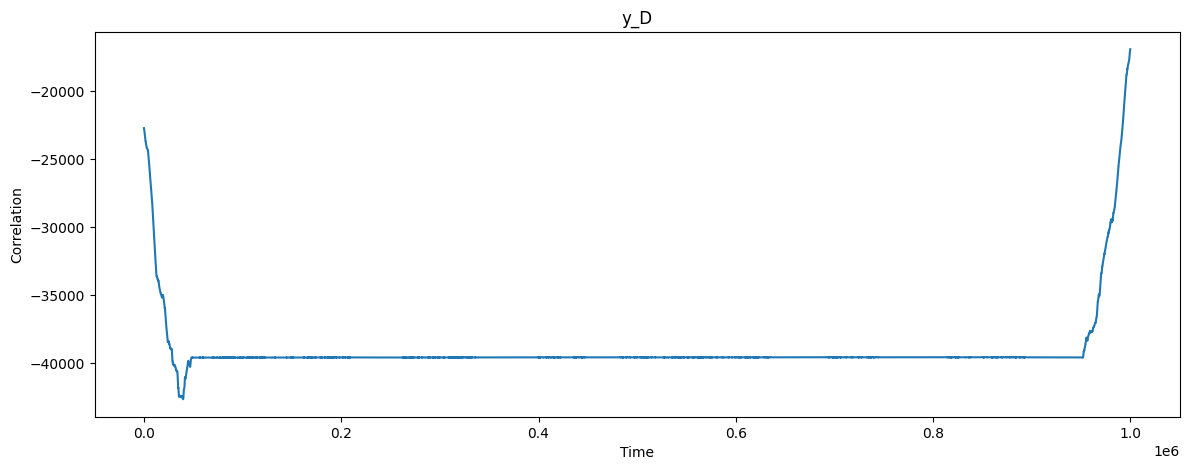

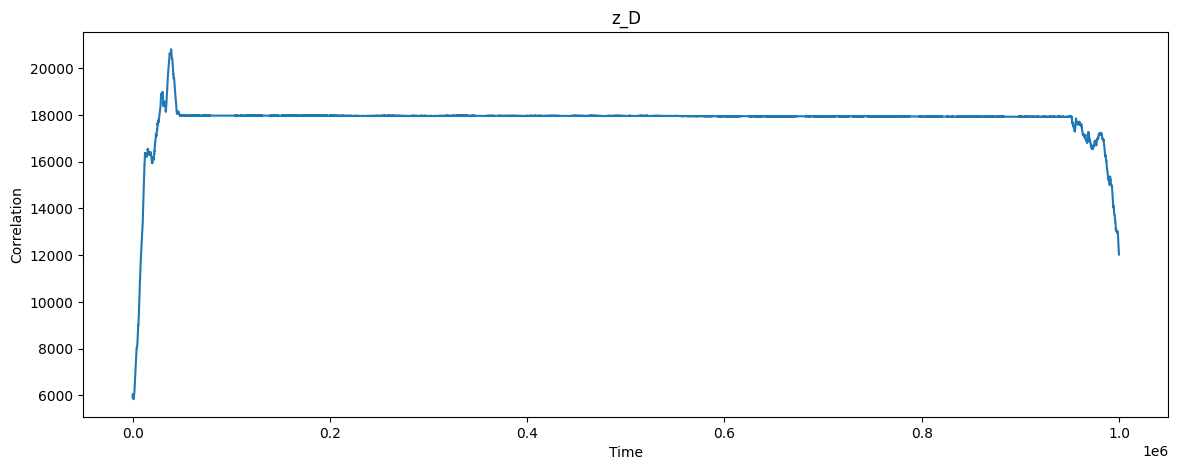

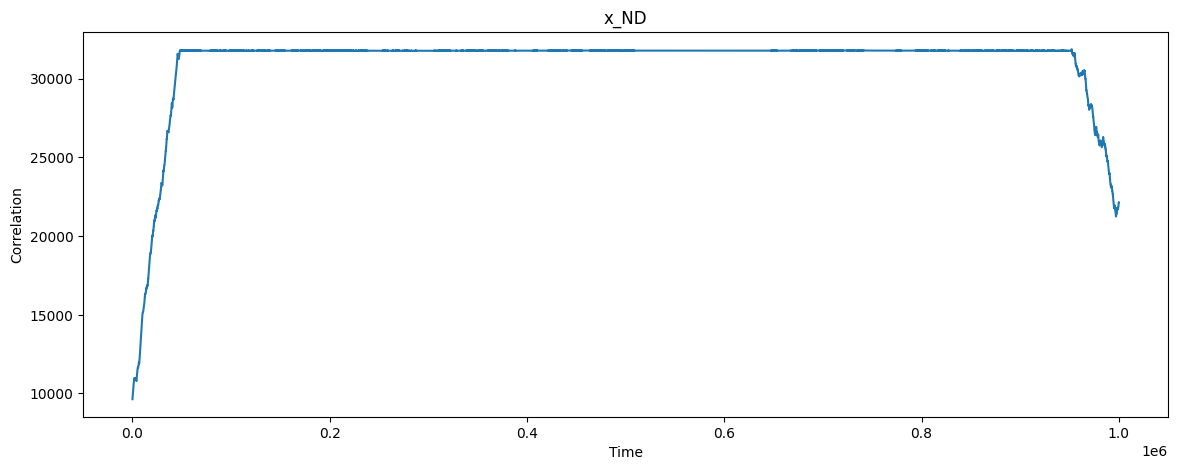

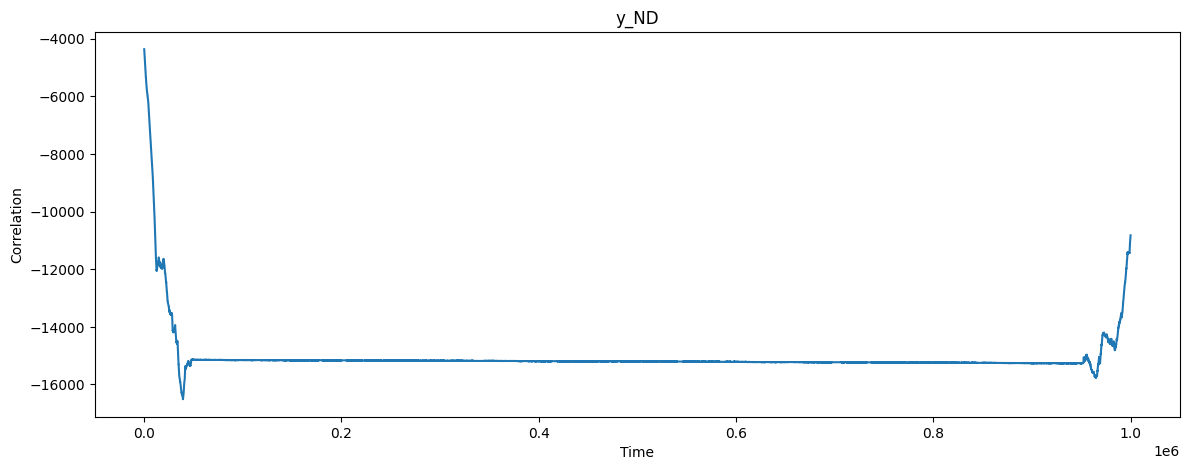

In [39]:
# Plotting singularly each axis


datasets = [correlation[:,0], correlation[:,1], correlation[:,2], correlation[:,3], correlation[:,4], correlation[:,5]]
titles = ['x_D', 'x_D', 'y_D', 'z_D', 'x_ND', 'y_ND', 'z_ND']


for data, title in zip(datasets, titles):
    plt.figure(figsize=(14, 5))
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Correlation')
    plt.title(title)
    plt.show()
